In [245]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import scipy.linalg as la

from scipy.linalg import expm
from qiskit.quantum_info import Statevector, partial_trace, Operator, DensityMatrix
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector

np.set_printoptions(precision=3)

In [323]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import scipy.linalg as la

from scipy.linalg import expm
from qiskit.quantum_info import Statevector, partial_trace, Operator, DensityMatrix
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector

np.set_printoptions(precision=3)


def get_H0(N):
    """The uniform matrix"""
    v = get_v0(N)
    return np.matmul(v, v.T.conj())

def get_H0_r(N):
    m = np.matrix([[1/N, np.sqrt(N-1)/N],
                  [np.sqrt(N-1)/N, (N-1)/N]], dtype=complex)
    return m

def get_v0(N):
    return np.ones((N,1))*(1/np.sqrt(N))
    
def get_vp(N):
    pv = np.zeros((N,1))
    pv[N-1] = 1
    return pv
    
def get_vp2(N):
    pv = np.zeros((N,1))
    pv[0] = 1
    return pv

def get_Hp(N):
    pv = get_vp(N)
    return np.matmul(pv, pv.T.conj())

def get_Hp_r():
    m = np.matrix([[1, 0],
                  [0, 0]])
    return m

def get_H_op(delt, n, H):
    """
    Input:
        delt: time interval
        n: number of qubits
        H: Hamiltonian matrix
    return Operator exp(-itH)
    """
    H = H*(-1j*delt)
    exp_H = expm(H)
    h = QuantumCircuit(n, name = 'H_op')
    h.unitary(exp_H, range(n))
    return h.to_gate()

def get_f(t, epsilon, N):
    """
    Time evolve function
    Input:
        t: time point
        epsilon: error value
        N: 2**n
    return value from 0 to 1
    """
    arg = ((2*epsilon*np.sqrt(N-1)*t)/N - np.arctan(np.sqrt(N-1)))
    num = np.tan(arg) / np.sqrt(N-1)
    den = 1 + num
    result = 0.5 * den
    return result

def get_adiabatic_T(epsilon, N):
    t1 = 1/(2*epsilon)
    t2 = N/np.sqrt(N-1)
    t3 = np.arctan((np.sqrt(N-1)))+np.arctan(np.sqrt(N-1))
    return t1*t2*t3

def get_simulation_T(a):
    return np.pi/(2*a)

def get_R(epsilon, N):
    """get the total iteration R"""
    return (int)(np.sqrt(N)/(epsilon**3))

def get_state(qc):
    m = DensityMatrix(qc)
    v = m.to_statevector()
    return v
    
def get_Epsilon1(final_vector, marked_vector):
    """
    get the epsilon of the result, should lower than the theoretical epsilon

    """
    distance_vector = final_vector.copy() - marked_vector.copy()
    values = np.matmul(distance_vector.conj().T,distance_vector)
    return np.sqrt(values)

def get_Epsilon2(v1, v2):
    """return from 0 to 1"""
    res = np.matmul(v1.T.conj(), v2)
    return (1-abs(res)**2)[0]

def get_eH(t, H):
    m = H*(-1j*t)
    exp_H = expm(m)
    return exp_H

def get_norm(v):
    return np.sqrt(np.matmul(v.T.conj(), v))

def normalize_vector(v):
    n = get_norm(v)
    v = v/n
    return v

## Compare two ways to express the error

Total time T: 4.836798304624582
Total iteration R: 16
State: [-0.089-0.352j -0.089-0.352j -0.089-0.352j  0.778+0.j   ]
E1: (0.6667765783138989+0j)
E2: [0.395]
[(0.7653668647301795-2.6822323059935534e-18j), (0.7653668647301795+0j), (0.7623112987096292+0j), (0.754928788066416+0j), (0.7428850966850904+0j), (0.7263897655993636+0j), (0.7059596291026697+0j), (0.6822655883969307+0j), (0.6560453390314438+0j), (0.6280735888776753+0j), (0.5991817384568694+0j), (0.5703222179706695+0j), (0.5426786345851032+0j), (0.5178272660404558+0j), (0.4979491969928647+0j), (0.48605440726895643+0j)]


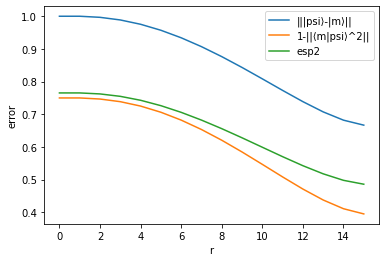

In [293]:
n = 2
N = 2**n
epsilon = 0.5

rs = []
es1 = []
es2 = []
es2p = []

T = getT(epsilon, N)
R = getR(epsilon, N)

circ = QuantumCircuit(n)
circ.h(range(n))

for r in range(0, R):
    t = r*(T/R)
    H0 = np.identity(N) - init_hamiltonian(N)
    Hp = np.identity(N) - problem_hamiltonian(N)
    circ.append(H_op(T/R,n,(1-f(t,epsilon,N))*H0), range(n))
    circ.append(H_op(T/R,n,f(t,epsilon,N)*Hp), range(n))

    rs.append(r)
    state = get_state(circ)
    v = trans(state.data, N)
    vp = problem_vector(N)
    e1 = get_Epsilon1(v, vp)
    e2 = get_Epsilon2(v, vp)
    
    es1.append(e1)
    es2.append(e2)
    es2p.append(np.sqrt(np.kron(v-vp))
#     es2p.append(np.sqrt(2-2*np.sqrt(inner_product(v, vp))))


print("Total time T: " +str(T))
print("Total iteration R: " +str(R))
print("State: " +str(state.data))
print("E1: " + str(get_Epsilon1(trans(state.data, N), problem_vector(N))))
print("E2: " + str(get_Epsilon2(trans(state.data, N), problem_vector(N))))

plt.plot(rs, es1, label="|||psi⟩-|m⟩||")
plt.plot(rs, es2, label="1-||⟨m|psi⟩^2||")
plt.plot(rs, es2p, label="esp2")
plt.xlabel("r")
plt.ylabel("error")
plt.legend()

print(es2p)

## Simulate reduced matrix adiabatic e^H

Total time T: 13.61344425034588
Total iteration R: 62
State: [[ 0.678-0.351j]
 [-0.57 +0.306j]]
E1: [[1.772+0.j]]
E2: [0.582]


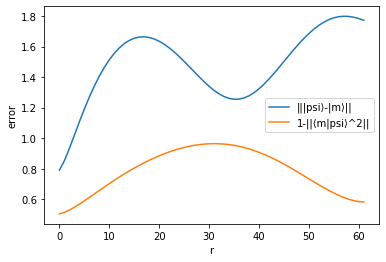

In [218]:
n = 4
N = 2**n
epsilon = 0.4

rs = []
states = []
es1 = []
es2 = []
ns = []

T = getT(epsilon, N)
R = getR(epsilon, N)
a = 1/np.sqrt(N)
delt = T/R
state = init_vector(2)

for r in range(0, R):
    t = r*(T/R)
    op = get_eH(a, delt, f(t,epsilon,N))
    state = np.dot(op, state)
    state = normalize_vector(state)
    
    rs.append(r)
    states.append(state)
    es1.append(getEpsilon1(state, 2)[0][0])
    es2.append(getEpsilon2(state, problem_vector(2))[0])
    ns.append(get_norm(state)[0][0])


print("Total time T: " +str(T))
print("Total iteration R: " +str(R))
print("State: " +str(state))
print("E1: " + str(getEpsilon1(state, 2)))
print("E2: " + str(getEpsilon2(state, problem_vector(2))))


plt.plot(rs, es1, label="|||psi⟩-|m⟩||")
plt.plot(rs, es2, label="1-||⟨m|psi⟩^2||")
plt.xlabel("r")
plt.ylabel("error")
plt.legend()


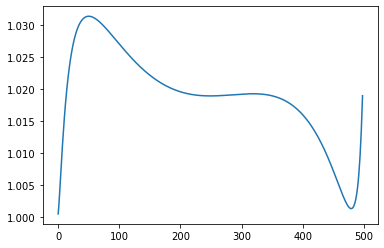

In [192]:
    # print(ns)
plt.plot(rs, ns)

## Simulate reduced matrix e^H

In [296]:
n = 1
N = 2**n

a = 1/np.sqrt(N)
T = np.pi/(2*a)
R = getR(epsilon, N)
delt = T/R
state = init_vector(2)

op = get_reduced_matrix_eH(a, delt, T)
state = np.dot(op, state)

print("State: " +str(state))
print("E1: " + str(getEpsilon1(state, 2)))
print("E2: " + str(getEpsilon2(state, problem_vector(2))))

State: [[-0.173+0.596j]
 [-0.173+0.596j]]
E1: [[1.455+0.j]]
E2: [0.615]


In [333]:
import cmath

def get_m(N, R):
    m = np.matrix([[(2/N)-1,-2*(np.sqrt(N-1)/N)],
                 [2*(np.sqrt(N-1)/N),(2/N)-1]])
    return m**R

n=4
N = 2**n
R = (int)(np.pi*np.sqrt(N)/4)
m = get_m(N, R)
res = np.dot(m, get_vp(2))
print(res)
print(get_Epsilon2(res, get_vp2(2)))

[[-0.999]
 [-0.055]]
[[0.003]]


In [335]:
def uniform_matrix(n):
    N = 2**n
    v = np.ones((N,1))*(1/np.sqrt(N))
    m = np.matmul(v, v.T.conj())
    return m

def H1_op(delt, n):
    N = 2**n
    h1 = QuantumCircuit(n, name='H1')
    H= np.zeros((N,N))
    H[N-1][N-1] = 1
    H = H*(-1j*delt)
    exp_H = expm(H)
    h1.unitary(exp_H, range(n))
    return h1.to_gate()

def H2_op(delt, n):
    N = 2**n
    h2 = QuantumCircuit(n, name='H2')
    H = uniform_matrix(n)
    H = H*(-1j*delt)
    exp_H = expm(H)
    h2.unitary(exp_H, range(n))
    return h2.to_gate()

sim_h = QuantumCircuit(n)
sim_h.h(range(n))

r = (int)(np.pi*np.sqrt(N)/4)
for _ in range(r):
    sim_h.append(H1_op(np.pi,n), range(n))
    sim_h.append(H2_op(np.pi,n), range(n))
    
res = Statevector(sim_h).data
print(get_Epsilon2(res, get_vp(N)))

0.038681030273439276
